In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
#I added from - https://stackoverflow.com/questions/11616260/how-to-get-all-objects-with-a-date-that-fall-in-a-specific-month-sqlalchemy/31641488
from sqlalchemy import extract  
from sqlalchemy import desc,asc
import calendar


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
datas = engine.execute('SELECT Date, prcp FROM Measurement DESC LIMIT 5').fetchall()
datas

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None)]

In [12]:
data_df = pd.DataFrame(datas)
data_df

,0,1
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-06,NaN


In [13]:
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
first_date = session.query(Measurement.date).order_by(Measurement.date.asc()).first().date


In [14]:
print(last_date)
print(first_date)

2017-08-23
2010-01-01


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
twelve_mo_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
prcp_result = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= twelve_mo_ago).all()


In [16]:
# Calculate the date 1 year ago from the last data point in the database
#twelve_mo_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
twelve_mo_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(twelve_mo_ago)


2016-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_result,columns=['Date','Precipitation'])
prcp_df.set_index("Date")

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [20]:
# Sort the dataframe by date
#prcp_df.sort_values(by="Date", ascending=True)
prcp_df.sort_index()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [22]:
prcp_df.to_json('prcp.json')

![precipitation](Images/precipitation.png)

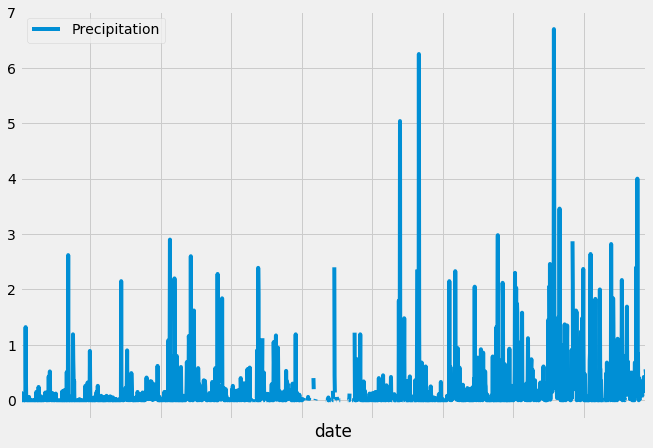

In [18]:

prcp_df.plot(figsize=(10,7))

plt.xlabel('date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    ) #

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
station_qty = session.query(Station.name).count()

station_qty

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Station.station,func.count(Measurement.station))\
    .filter (Measurement.station == Station.station)\
    .group_by(Station.name)\
    .order_by(desc(func.count(Measurement.station))).all()
station_activity
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
session.query()

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = session.query(Station.station,
                           func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
    filter (Measurement.station == Station.station).\
    filter(Station.station == 'USC00519281').all()
temp_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [24]:
# Choose the station with the highest number of temperature observations.


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelve_mo_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
highest_tobs_result = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= twelve_mo_ago).all()
highest_tobs_result
highest_tobs_result_df = pd.DataFrame(highest_tobs_result,columns=['Tobs'])

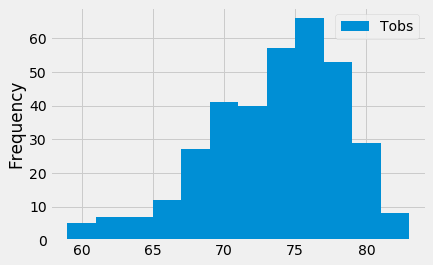

In [25]:
highest_tobs_result_df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_stats = calc_temps('2017-01-01', '2017-12-31')
print(trip_stats)

[(58.0, 74.14387974230493, 87.0)]


In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin, tavg, tmax = calc_temps('2017-01-01', '2017-01-07')[0]

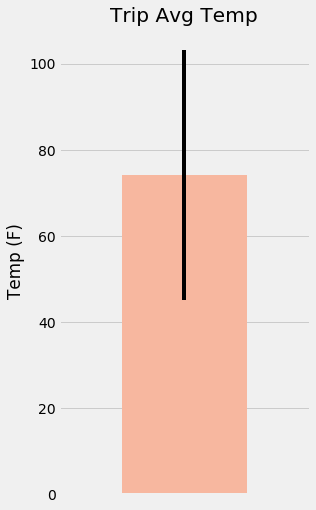

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_temp_df = pd.DataFrame(trip_stats, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_temp_df['Avg Temp']
y_error_bar = trip_temp_df.iloc[0]['Max Temp'] - trip_temp_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=y_error_bar, figsize=(4,8), color='#F7B79F')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
#plt.savefig("Output/TripTempSummary.png")
plt.show()

## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [65]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals =[]


# Set the start and end date of the trip
start = dt.datetime.strptime("07-01", "%m-%d")
end = dt.datetime.strptime("07-07", "%m-%d")
# Use the start and end date to create a range of dates



date_range = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_range:
    normals.append(date.strftime("%m-%d"))

    
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for normal in normals:
    print(daily_normals(normal))
    #trip_dates.append(date.strftime("%m-%d"))

[(67.0, 74.77777777777777, 81.0)]
[(68.0, 75.40384615384616, 82.0)]
[(68.0, 75.32075471698113, 87.0)]
[(70.0, 76.57142857142857, 81.0)]
[(66.0, 75.0, 81.0)]
[(69.0, 75.0, 81.0)]


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
